<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# NRPy+ Tutorial: Solving the Scalar Wave Equation in Pure Python

## Authors: Zach Etienne, Patrick Nelson, Terrence Pierre Jacques, Thiago Assumpção, Leo Werneck, Brandon Clark

(*Note on Authors*: Zach wrote the NRPy+ infrastructure, as well as this notebook and its Python code; Patrick wrote the first version of the NRPy+-based Einstein Toolkit thorns for solving the scalar wave equation in 2018; Terrence rewrote these thorns to latest NRPy+ standards in 2020, along the lines of the [`BaikalETK` thorns](Tutorial-BaikalETK.ipynb); Thiago extended the scalar wave initial data infrastructure and contributed fixes to the original NRPy+ scalar wave notebooks; Leo created the boundary condition animation below; and Brandon established NRPy+ notebook formatting standards.)

This notebook was first written as a tutorial to introduce NRPy+ during the 2020 Einstein Toolkit Workshop.

## In this tutorial we will construct and validate a pure Python code that solves the scalar wave equation $\partial_t^2 u = c^2 \nabla^2 u$ in Cartesian coordinates, to review the basic components of a PDE solver in preparation for using NRPy+

This notebook was written to explicitly outline the basic algorithms for numerically solving [hyperbolic PDEs](https://en.wikipedia.org/wiki/Hyperbolic_partial_differential_equation), **including Einstein's equations of general relativity in e.g., the BSSN formalism**.

While the codes here are written by hand, the objective of the notebook is to act as a reference to NRPy+ can be used to generate much of the code *automatically*, greatly reducing the possibility of human error. 

**Notebook Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** The code developed in this tutorial notebook has been confirmed to converge to the exact solution at the expected rate, as documented below.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 0](#prereqs): Prerequisites & Additional Reading
1. [Step 1](#intro): Introduction: The scalar wave equation
1. [Step 1.a](#problem_statement): Mathematical problem statement
1. [Step 1.b](#solution): Solution
1. [Step 1](#problem_statement): Introduction: Problem Statement
1. [Step 2](#initializenrpy): A NRPy+-based C code for solving the scalar wave equation
1. [Step 2](#rhss1d): Scalar Wave RHSs in One Spatial Dimension, Fourth-Order Finite Differencing
1. [Step 3](#rhss3d): Scalar Wave RHSs in Three Spatial Dimensions, Tenth-Order Finite Differencing
    1. [Step 3.a](#code_validation1): Code Validation against `ScalarWave.ScalarWave_RHSs` NRPy+ module
1. [Step 4](#id): Setting up Initial Data for the Scalar Wave Equation
    1. [Step 4.a](#planewave): The Monochromatic Plane-Wave Solution
    1. [Step 4.b](#sphericalgaussian): The Spherical Gaussian Solution (*Courtesy Thiago Assumpção*)
1. [Step 5](#code_validation2): Code Validation against `ScalarWave.InitialData` NRPy+ module
1. [Step 6](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='prereqs'></a>

# Step 0: Prerequisites & Additional Reading \[Back to [top](#toc)\]
$$\label{prereqs}$$


This tutorial assumes that the user has some basic familiarity with computer programming and computational physics or numerical analysis.

For additional reading, please consult the following links:

* [Numerical Analysis & Basic Mathematics](http://astro.phys.wvu.edu/zetienne/MATH521-f2018/additional_reading.html)
* [Numerical Recipes in C](http://www.numerical.recipes/) Feel free to use the *free* "obsolete" (but not really!) versions. Note that Numerical Recipes was written by numerical relativists!

# Introduction: The scalar wave equation

Here we will write a Python code (based in [NumPy](https://numpy.org/)) to numerically solve the scalar wave equation

$$\partial_t^2 u(t,x,y,z) = c^2 \nabla^2 u(t,x,y,z),$$

given initial conditions $u(t=t_0,x,y,z)$.

## Mathematical problem statement

We wish to numerically solve the scalar wave equation as an [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem) in Cartesian coordinates:
$$\partial_t^2 u = c^2 \nabla^2 u,$$
where $u$ (the amplitude of the wave) is a function of time and space: $u = u(t,x,y,...)$ (spatial dimension as-yet unspecified) and $c$ is the wave speed, subject to some initial condition

$$u(0,x,y,...) = f(x,y,...)$$

and suitable spatial boundary conditions (we'll stick with simple extrapolation boundary conditions at first).

As described in the next section, we will find it quite useful to define
$$v(t,x,y,...) = \partial_t u(t,x,y,...).$$

In this way, the second-order PDE is reduced to a set of two coupled first-order PDEs

\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \nabla^2 u.
\end{align}

We will use NRPy+ to generate efficient C codes capable of generating both initial data $u(0,x,y,...) = f(x,y,...)$; $v(0,x,y,...)=g(x,y,...)$, as well as finite-difference expressions for the right-hand sides of the above expressions. These expressions are needed within the *Method of Lines* to "integrate" the solution forward in time.

### Solution & Initial Conditions

Here we will implement the spherical Gaussian solution to the scalar wave equation, consists of ingoing and outgoing wave fronts:
\begin{align}
u(r,t) &= u_{\rm out}(r,t) + u_{\rm in}(r,t) + 1,\ \ \text{where}\\
u_{\rm out}(r,t) &=\frac{r-ct}{r} \exp\left[\frac{-(r-ct)^2}{2 \sigma^2}\right] \\
u_{\rm in}(r,t) &=\frac{r+ct}{r} \exp\left[\frac{-(r+ct)^2}{2 \sigma^2}\right] \\
\end{align}
where $c$ is the wavespeed, and $\sigma$ is the width of the Gaussian (i.e., the "standard deviation"). Next we'll demonstrate using SymPy (a computer algebra system written in Python, on which NRPy+ depends) that the above indeed is a solution to the scalar wave equation.

In Cartesian coordinates we have
$$
\partial_t^2 u(t,x,y,z) = c^2 \nabla^2 u(t,x,y,z),
$$
and we know that
$$
r = \sqrt{x^2+y^2+z^2},
$$
so

In [1]:
import sympy as sp  # SymPy: The Python computer algebra package upon which NRPy+ depends

# Declare independent variables t,x,y,z as (real-valued) SymPy symbols
t,x,y,z = sp.symbols('t x y z', real=True)

# Declare the parameters c and sigma as (real-valued) SymPy symbols as well.
#   In NRPy+ we'd declare these as NRPy+ *parameters*
c, sigma, uoffset = sp.symbols('c sigma uoffset', real=True)

# Then define r:
r = sp.sqrt(x**2 + y**2 + z**2)

Recall the solution is given by
\begin{align}
u(r,t) &= u_{\rm out}(r,t) + u_{\rm in}(r,t) + u_o,\ \ \text{where}\\
u_{\rm out}(r,t) &=\frac{r-ct}{r} \exp\left[\frac{-(r-ct)^2}{2 \sigma^2}\right] \\
u_{\rm in}(r,t) &=\frac{r+ct}{r} \exp\left[\frac{-(r+ct)^2}{2 \sigma^2}\right],
\end{align}
whre $u_o$ is a freely specifiable constant offset.

Let's implement this now:

In [2]:
# Next set up the solution u(t,x,y,z).

# Then the outgoing wave
u_out = (r - c*t)/r * sp.exp(-(r - c*t)**2 / (2*sigma**2))
# ... and the ingoing wave
u_in  = (r + c*t)/r * sp.exp(-(r + c*t)**2 / (2*sigma**2))

u_exact = u_out + u_in + uoffset

# ... and then v, which is the time derivative of u:
v_exact = sp.diff(u_exact, t)

Now let's confirm the solution indeed solves the PDE:
$$
\partial_t^2 u(t,x,y,z) = c^2 \nabla^2 u(t,x,y,z),
$$
by confirming that indeed
$$
c^2 \nabla^2 u(t,x,y,z) - \partial_t^2 u(t,x,y,z) = 0,
$$
using SymPy to compute the second derivatives of $u$ symbolically:

In [3]:
# Finally confirm that the solution indeed solves the PDE,
#   by subtracting the left-hand-side from the right-hand-side
#   of the equation and simplifying; we should get zero
scalarwave_lhs = sp.diff(u_exact, t, 2)
scalarwave_rhs = c**2 * (sp.diff(u_exact, x, 2) +
                         sp.diff(u_exact, y, 2) +
                         sp.diff(u_exact, z, 2))

# Print the result!
# print("(rhs - lhs) = %s" % sp.simplify(scalarwave_rhs - scalarwave_lhs))

We will choose the solution at $t=0$, $u(t=0,x,y,z)$, as our initial data and adopt the Method of Lines to advance the solution forward in time (i.e., solve the initial value problem).

### The Method of Lines

Once we have initial data, we "evolve it forward in time", using the [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html). In short, the Method of Lines enables us to handle 
1. the **spatial derivatives** of an initial value problem PDE using **standard finite difference approaches**, and
2. the **temporal derivatives** of an initial value problem PDE using **standard strategies for solving ordinary differential equations (ODEs)**, so long as the initial value problem PDE can be written in the form
$$\partial_t \vec{f} = \mathbf{M}\ \vec{f},$$
where $\mathbf{M}$ is an $N\times N$ matrix filled with differential operators that act on the $N$-element column vector $\vec{f}$. $\mathbf{M}$ may not contain $t$ or time derivatives explicitly; only *spatial* partial derivatives are allowed to appear inside $\mathbf{M}$. The scalar wave equation as written in the [previous module](Tutorial-ScalarWave.ipynb)
\begin{equation}
\partial_t 
\begin{bmatrix}
u \\
v 
\end{bmatrix}=
\begin{bmatrix}
0 & 1 \\
c^2 \nabla^2  & 0 
\end{bmatrix}
\begin{bmatrix}
u \\
v 
\end{bmatrix}
\end{equation}
satisfies this requirement. 

Thus we can treat the spatial derivatives $\nabla^2 u$ of the scalar wave equation  using **standard finite-difference approaches**, and the temporal derivatives $\partial_t u$ and $\partial_t v$ using **standard approaches for solving ODEs**. In [the next module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will apply the highly robust [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4), used widely for numerically solving ODEs, to "march" (integrate) the solution vector $\vec{f}$ forward in time from its initial value ("initial data").

### Basic Algorithm

The basic algorithm for solving the scalar wave equation [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem), based on the Method of Lines (see section above) is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>. We will review how NRPy+ generates these core components in this module.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate scalar wave RHS expressions.</font>
    1. Apply boundary conditions.

**We refer to the right-hand side of the equation $\partial_t \vec{f} = \mathbf{M}\ \vec{f}$ as the RHS. In this case, we refer to the $\mathbf{M}\ \vec{f}$ as the "scalar wave RHSs".** In the following sections we will 

This notebook implements a standalone Python code to solve the above equation in 3D *by hand* using [NumPy](https://numpy.org/), to motivate the use of NRPy+.

<a id='initializenrpy'></a>

# Step 1: A NumPy-based scalar wave equation solver \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

Recall that the basic algorithm is as follows

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. Set gridfunction values to initial data.
1. Evolve the system forward in time using the Runge-Kutta fourth-order approach for time integration. At each RK4 substep, do the following:
    1. Evaluate scalar wave RHS expressions.
    1. Apply boundary conditions.

Recall also we are solving 

\begin{equation}
\partial_t 
\begin{bmatrix}
u \\
v 
\end{bmatrix}=
\begin{bmatrix}
0 & 1 \\
c^2 \nabla^2  & 0 
\end{bmatrix}
\begin{bmatrix}
u \\
v 
\end{bmatrix}
\end{equation}

We will store the numerical solution $u$ and its time derivative $v$, *at a given instant in time* on a three-dimensional numerical grid. Since these variables are defined at each point on the numerical grid, we call them *gridfunctions*.

## Setting up the numerical grid

We will solve the scalar wave equation on a uniform Cartesian grid with `Nx` by `Ny` by `Nz` coordinate points in the $x$, $y$, and $z$ directions respectively. Since the grid is uniform, we can describe the $x$ coordinate of any gridpoint with a single integer $i$, and the same holds true for $y$ and $z$, for which we will use integers $j$ and $k$. Thus we will label each gridpoint $(x_i,y_j,z_k)$.

Let's choose a "cell-centered" grid, which will store the solution at points
$$
x_i \in \{..., -\frac{3}{2} \Delta x, -\frac{1}{2} \Delta x, +\frac{1}{2} \Delta x, +\frac{3}{2} \Delta x  ...\};
$$
and we will allow for two additional ghost zones on the outer boundary to account for the fourth-order finite differencing we will implement to numerically compute $\nabla^2 u$. Thus the expression for computing $x_i$ will be

$$
x_i = x_{\rm min} + \left( (i-\text{NGHOSTS}) + \frac{1}{2} \right) \Delta x,
$$
where $\Delta x$ is the spacing between gridpoints, and $x_{\rm min}$ denotes the minimum grid value in $x$. We will solve this equation on a cube centered on the origin with the `domain_size=10`, where $x_{\rm min}=$`-domain_size`, $y_{\rm min}=$`-domain_size`, $z_{\rm min}=$`-domain_size`, $x_{\rm max}=$`+domain_size`, and so forth. We'll also choose `Nx=Ny=Nz`, so that

$$
\Delta x = \Delta y = \Delta z = \frac{x_{\rm max}-x_{\rm min}}{\text{Nx}}.
$$

In [4]:
import numpy as np  # NumPy: A numerical methods Python module
domain_size = 1.0

Nx = Ny = Nz = 24
# We add two ghostzones for the outer boundary; needed because our
#   finite-differencing stencils are two gridpoints wide.
NGHOSTS = 2

xx = np.zeros(Nx+2*NGHOSTS)
yy = np.zeros(Ny+2*NGHOSTS)
zz = np.zeros(Nz+2*NGHOSTS)

xmin = ymin = zmin = -domain_size
xmax = ymax = zmax = +domain_size

dx = (xmax - xmin) / Nx
for i in range(Nx + 2*NGHOSTS):
    xx[i] = xmin + (i - NGHOSTS + 0.5) * dx
dy = (ymax - ymin) / Ny
for j in range(Ny + 2*NGHOSTS):
    yy[j] = ymin + (j - NGHOSTS + 0.5) * dy
dz = (zmax - zmin) / Nz
for k in range(Nz + 2*NGHOSTS):
    zz[k] = zmin + (k - NGHOSTS + 0.5) * dz

Next we set the free parameters for the scalar wave solution:

In [5]:
# Set free parameters
freeparam_c     = 1.0  # wave speed
freeparam_sigma = 3.0  # width of Gaussian
freeparam_uoffset=1.0  # offset of solution

Then we set the timestep, which is governed by the [CFL condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition), and the final time `t_final` (assuming we start at $t=0$), so that the points closest to origin aren't affected by the approximate boundary condition:

In [6]:
dt = 0.5*min(dx,min(dy,dz))/freeparam_c
t_final = domain_size*0.5

Now we'll set up `exact_solution_all_points(time, u, v)`, which numerically evaluates the solution for $u$ and $v$ at all gridpoints at a given numerical time `time`.

Recall the exact solution is given by
\begin{align}
u(r,t) &= u_{\rm out}(r,t) + u_{\rm in}(r,t) + 1,\ \ \text{where}\\
u_{\rm out}(r,t) &=\frac{r-ct}{r} \exp\left[\frac{-(r-ct)^2}{2 \sigma^2}\right] \\
u_{\rm in}(r,t) &=\frac{r+ct}{r} \exp\left[\frac{-(r+ct)^2}{2 \sigma^2}\right].
\end{align}

*Exercise for students: Prove that at $t=0$, $v=\partial_t u \equiv 0$.*

The problem is, SymPy expressions need to be converted to NumPy expressions; otherwise using functions like `sp.N()` will be *incredibly slow*. So we attempt to fix this by some simple string manipulations, some for $v$ were done by hand using the below Python function.

In [7]:
def opt_string_replace(input):
    return input.replace("sqrt","np.sqrt").replace("exp","np.exp").\
      replace("x**2","x_i*x_i").replace("y**2","y_j*y_j").replace("z**2","z_k*z_k").\
      replace("c*t", "freeparam_c*time").replace("sigma", "freeparam_sigma")

print(opt_string_replace(str(u_exact)))
print(opt_string_replace(str(v_exact)))

uoffset + (-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + (freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k)
c*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) - c*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + c*(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/(freeparam_sigma**2*np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k)) - c*(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*

In [8]:
def exact_solution_single_pt_u(time, x_i,y_j,z_k):
                # Kludge: The following expressions were pasted from above:
                return (-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + (freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + freeparam_uoffset
def exact_solution_single_pt_v(time, x_i,y_j,z_k):
                # Kludge: The following expressions were pasted from above, and edited slightly by hand
                #         to convert the symbol c to the numerical value for c, freeparam_c
                return freeparam_c*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) - freeparam_c*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k) + freeparam_c*(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(-freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/(freeparam_sigma**2*np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k)) - freeparam_c*(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2*np.exp(-(freeparam_c*time + np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))**2/(2*freeparam_sigma**2))/(freeparam_sigma**2*np.sqrt(x_i*x_i + y_j*y_j + z_k*z_k))

def exact_solution_all_points(time, u, v):
    for k in range(0, Nz+2*NGHOSTS):
        z_k = zz[k]
        for j in range(0, Ny+2*NGHOSTS):
            y_j = yy[j]
            for i in range(0, Nx+2*NGHOSTS):
                x_i = xx[i]
                u[IDX3D(i,j,k)] = exact_solution_single_pt_u(time, x_i,y_j,z_k)
                v[IDX3D(i,j,k)] = exact_solution_single_pt_v(time, x_i,y_j,z_k)

To store the solution $u$ and $v$ at all gridpoints on our numerical grid cube requires 

`2*Nx*Ny*Nz*double`

bytes of memory, where `double` is the amount of memory storage (in bytes) needed to store one [double-precision number](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) (this is 8, by the way).

In [9]:
# Allocate memory for gridfunctions. We need ghostzones
u = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))

As is done in the Einstein Toolkit and native NRPy+ codes, instead of declaring multi-dimensional arrays (e.g., a 3D array), we will instead declare $u$ and $v$ as *one-dimensional* arrays `u[ijk]` and `v[ijk]`, each with `(Nx+2*NGHOSTS)*(Ny+2*NGHOSTS)*(Nz+2*NGHOSTS)` gridpoints. To access data an arbitrary point $(x_i,y_j,z_k)$, we need only call a simple function to find the correct index `ijk` given the grid indices `i`, `j`, and `k`, which label the point $(x_i,y_j,z_k)$:

$$
\verb|
(i,j,k) = i + Nx*j + Nx*Ny*k = i + Nx*(j + Ny*k)|
$$

In [10]:
# Define the indexing macro
def IDX3D(i,j,k):
    return i + (Nx+2*NGHOSTS)*(j + (Ny+2*NGHOSTS)*k)

Next we define the right-hand sides of the $u$ and $v$ equations:
\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \nabla^2 u.
\end{align}

Again we'll approximate the $\nabla^2 u$ using fourth-order [finite-difference derivatives] (https://en.wikipedia.org/wiki/Finite_difference) (also see [the NRPy+ tutorial on how to compute these expressions automatically or by hand using simple matrix methods](Tutorial-Finite_Difference_Derivatives.ipynb)).

Here we'll just use the [Wikipedia article on finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient) to construct the expressions for

$$
(\nabla u)_{i,j,k} = (\partial_x^2 u)_{i,j,k} + (\partial_y^2 u)_{i,j,k} + (\partial_z^2 u)_{i,j,k}:
$$

That is to say, the fourth-order finite difference stencil for $(\partial_x^2 u)_{i,j,k}$ is written
\begin{align}
(\partial_x^2 u)_{i,j,k} &= \left[-\frac{1}{12} u_{i-2,j,k} + \frac{4}{3} u_{i-1,j,k} - \frac{5}{2} u_{i,j,k} + \frac{4}{3} u_{i+1,j,k} - \frac{1}{12} u_{i+2,j,k}\right]\frac{1}{(\Delta x)^2} \\
&= \left[-\frac{1}{12} \left(u_{i-2,j,k} + u_{i+2,j,k}\right) + \frac{4}{3} \left(u_{i-1,j,k}+u_{i+1,j,k}\right) - \frac{5}{2} u_{i,j,k}\right]\frac{1}{(\Delta x)^2}
\end{align}

In [11]:
def eval_rhs_all_interior_points(u, v, u_rhs, v_rhs):
    # Notice that if we looped from e.g., k=0, then u[IDX3D(i,j,k-2)] would be OUT OF BOUNDS.
    for k in range(NGHOSTS, Nz+NGHOSTS):  # Recall the valid range of k is 0 to Nz+2*NGHOSTS, ...
        for j in range(NGHOSTS, Ny+NGHOSTS):  # ... similarly for j and i
            for i in range(NGHOSTS, Nx+NGHOSTS):
                u_rhs[IDX3D(i,j,k)] = v[IDX3D(i,j,k)]
                # First the x-component of nabla
                v_rhs[IDX3D(i,j,k)] = freeparam_c**2 * (-1./12. * (u[IDX3D(i-2,j,k)] + u[IDX3D(i+2,j,k)])
                                                        +4./3.  * (u[IDX3D(i-1,j,k)] + u[IDX3D(i+1,j,k)])
                                                        -5./2.  * u[IDX3D(i,j,k)])/(dx*dx)
                # Then the y-component of nabla
                v_rhs[IDX3D(i,j,k)]+= freeparam_c**2 * (-1./12. * (u[IDX3D(i,j-2,k)] + u[IDX3D(i,j+2,k)])
                                                        +4./3.  * (u[IDX3D(i,j-1,k)] + u[IDX3D(i,j+1,k)])
                                                        -5./2.  * u[IDX3D(i,j,k)])/(dy*dy)
                # and finally the y-component of nabla
                v_rhs[IDX3D(i,j,k)]+= freeparam_c**2 * (-1./12. * (u[IDX3D(i,j,k-2)] + u[IDX3D(i,j,k+2)])
                                                        +4./3.  * (u[IDX3D(i,j,k-1)] + u[IDX3D(i,j,k+1)])
                                                        -5./2.  * u[IDX3D(i,j,k)])/(dz*dz)

Notice that the above code does not fill the input gridfunctions $u$ and $v$ in the ghostzones, which will be updated at each Runge-Kutta substep (as outlined next). We will need to apply our spatial boundary conditions to fill in these points. For simplicity let's choose quadratic extrapolation boundary conditions.

For example, suppose we are on the lower boundary point in $x$: $u_{1,j,k}$. Then this boundary condition will be written as the quadratic [polynomial extrapolation](https://en.wikipedia.org/wiki/Polynomial_interpolation) taking data from the interior:
$$
u_{1,j,k} = 3 u_{2,j,k} - 3 u_{3,j,k} + u_{4,j,k}.
$$

Similarly for the upper boundary point in $x$, the condition becomes:
$$
u_{\text{Nx}-2,j,k} = 3 u_{\text{Nx}-3,j,k} - 3 u_{\text{Nx}-4,j,k} + u_{\text{Nx}-5,j,k}.
$$


We'll apply this algorithm from the innermost boundary point outward, using the approach of filling in the (green-colored) ghost zones as illustrated here in 2 dimensions (*courtesy Leo Werneck*). Extension to 3 dimensions is straightforward.

<img src="CurviBoundaryConditions/bdrycond_general_algorithm.gif" width="450" align="center">

In [12]:
def bc_face_update(gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2):
    for i2 in range(i2min,i2max):
        for i1 in range(i1min,i1max):
            for i0 in range(i0min,i0max):
                gf[IDX3D(i0,i1,i2)] = (+3.0*gf[IDX3D(i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]
                                       -3.0*gf[IDX3D(i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]
                                       +1.0*gf[IDX3D(i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)])

MAXFACE = -1  # Interp stencil reaches in the negative direction on upper (max) face
NUL     = +0
MINFACE = +1  # Interp stencil reaches in the positive direction on lower (min) face
def apply_extrapolation_bcs(u, v):
    for gf in [u,v]:
        imin = [NGHOSTS, NGHOSTS, NGHOSTS]
        imax = [Nx+NGHOSTS, Ny+NGHOSTS, Nz+NGHOSTS]
        for which_gz in range(NGHOSTS):
            # After updating each face, adjust imin[] and imax[]
            #   to reflect the newly-updated face extents.
            bc_face_update(gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]-=1
            bc_face_update(gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]+=1
            bc_face_update(gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]-=1
            bc_face_update(gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]+=1
            bc_face_update(gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]-=1
            bc_face_update(gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]+=1

Next we'll set up the Method of Lines routine for Runge-Kutta fourth order (RK4), which takes the solution at a given iteration in time $n$, and enables us to advance the solution forward to iteration $n+1$:

The [classic RK4 method](https://en.wikipedia.org/w/index.php?title=Runge%E2%80%93Kutta_methods&oldid=894771467) obtains the solution $y(t)$ at time $t_{n+1}$ from $t_n$ via:

\begin{align}
k_1 &= \Delta tf(y_n, t_n), \\
k_2 &= \Delta tf(y_n + \frac{1}{2}k_1, t_n + \frac{\Delta t}{2}), \\
k_3 &= \Delta tf(y_n + \frac{1}{2}k_2, t_n + \frac{\Delta t}{2}), \\
k_4 &= \Delta tf(y_n + k_3, t_n + \Delta t), \\
y_{n+1} &= y_n + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + \mathcal{O}\big((\Delta t)^5\big).
\end{align}

We will store $k_1$ through $k_4$ as additional gridfunctions, one each for $u$ and $v$, and another gridfunction for the input into $f()$. Note that our equations do not have explicit time dependence, so $f(y_n,t_n)=f(y_n)$:

In [13]:
u_tmp = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_tmp = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k1 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k1 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k2 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k2 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k3 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k3 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
u_k4 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))
v_k4 = np.zeros((Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS))

... then implement a single timestep by calling the `eval_rhs_all_interior_points()` function above with appropriate inputs. Recall that the RK4 algorithm is given by
\begin{align}
k_1 &= f(y_n, t_n), \\
k_2 &= f(y_n + \frac{1}{2}\Delta tk_1, t_n + \frac{\Delta t}{2}), \\
k_3 &= f(y_n + \frac{1}{2}\Delta tk_2, t_n + \frac{\Delta t}{2}), \\
k_4 &= f(y_n + \Delta tk_3, t_n + \Delta t), \\
y_{n+1} &= y_n + \frac{1}{6}\Delta t(k_1 + 2k_2 + 2k_3 + k_4) + \mathcal{O}\big((\Delta t)^5\big).
\end{align}

In [14]:
def one_RK_step():
    # Compute k_1
    eval_rhs_all_interior_points(u, v, u_k1, v_k1)
    # Compute inputs into k_2
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u_tmp[idx] = u[idx] + 0.5*dt*u_k1[idx]
        v_tmp[idx] = v[idx] + 0.5*dt*v_k1[idx]
    # Apply BCs to u_tmp and v_tmp:
    apply_extrapolation_bcs(u_tmp, v_tmp)
#     print("k1",u_tmp[IDX3D(int((Nx+2*NGHOSTS)/2), int((Ny+2*NGHOSTS)/2), int((Nz+2*NGHOSTS)/2))])

    # Compute k_2
    eval_rhs_all_interior_points(u_tmp, v_tmp, u_k2, v_k2)
    # Compute inputs into k_3
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u_tmp[idx] = u[idx] + 0.5*dt*u_k2[idx]
        v_tmp[idx] = v[idx] + 0.5*dt*v_k2[idx]
    # Apply BCs to u_tmp and v_tmp:
    apply_extrapolation_bcs(u_tmp, v_tmp)
#     print("k2",u_tmp[IDX3D(int((Nx+2*NGHOSTS)/2), int((Ny+2*NGHOSTS)/2), int((Nz+2*NGHOSTS)/2))])

    # Compute k_3
    eval_rhs_all_interior_points(u_tmp, v_tmp, u_k3, v_k3)
    # Compute inputs into k_4
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u_tmp[idx] = u[idx] + dt*u_k3[idx]
        v_tmp[idx] = v[idx] + dt*v_k3[idx]
    # Apply BCs to u_tmp and v_tmp:
    apply_extrapolation_bcs(u_tmp, v_tmp)
#     print("k3",u_tmp[IDX3D(int((Nx+2*NGHOSTS)/2), int((Ny+2*NGHOSTS)/2), int((Nz+2*NGHOSTS)/2))])

    # Compute k_4
    eval_rhs_all_interior_points(u_tmp, v_tmp, u_k4, v_k4)
    # Finally compute y_{n+1}
    for idx in range(0, (Nx+2*NGHOSTS) * (Ny+2*NGHOSTS) * (Nz+2*NGHOSTS)):
        u[idx] = u[idx] + (1.0/6.0)*dt*(u_k1[idx] + 2*u_k2[idx] + 2*u_k3[idx] + u_k4[idx])
        v[idx] = v[idx] + (1.0/6.0)*dt*(v_k1[idx] + 2*v_k2[idx] + 2*v_k3[idx] + v_k4[idx])
    # ... and apply BCs to the updated u and v:
    apply_extrapolation_bcs(u, v)
#     print("k4",u[IDX3D(int((Nx+2*NGHOSTS)/2), int((Ny+2*NGHOSTS)/2), int((Nz+2*NGHOSTS)/2))])

Finally we'll write the main driver function, which outputs the numerical solution at the closest point to the center of the numerical grid.

In [15]:
%%time

initial_time = 0.0

# First set up the initial data:
exact_solution_all_points(initial_time, u, v)

# Store the indices at the point closest to the origin
i_o = int((Nx+2*NGHOSTS)/2)
j_o = int((Ny+2*NGHOSTS)/2)
k_o = int((Nz+2*NGHOSTS)/2)
print("# Outputting data at (x,y,z) = (%.2f,%.2f,%.2f)" % (xx[i_o],yy[j_o],zz[k_o]))

def diagnostics(n):
    # Print the time and the value of the solution closest to the origin
    curr_time = initial_time + n*dt
    num   = u[IDX3D(i_o, j_o, k_o)]
    exact = exact_solution_single_pt_u(curr_time, xx[i_o],yy[j_o],zz[k_o])
    log10relerror = np.log10(max(1e-16, np.abs((num-exact)/exact)))
    return "%.2f %.2f %.12f %.12f\n" % (curr_time, log10relerror, num, exact)

# Output diagnostics at the initial time.
out_str = diagnostics(0)

# Then integrate forward in time:
n_final = int(t_final/dt + 0.5)  # add 0.5 to correct for rounding.
n_out_every = int(Nx/24.)  # Output every timestep for Nx=24; every other timestep for Nx=48; etc
import time  # for live benchmarking & estimates
start = time.time()
for n in range(0,n_final):
    ETA = "N/A"
    if n > 0:
        time_elapsed_in_seconds = time.time() - start
        seconds_per_n = time_elapsed_in_seconds/n
        time_remaining_m_field = int((n_final - n)*seconds_per_n/60)
        time_remaining_s_field = (n_final - n)*seconds_per_n - time_remaining_m_field*60
        ETA = str(time_remaining_m_field)+"m"+ '%.2f' % time_remaining_s_field + "s"
    print("# Integrating forward in time, to time %.3f . ETA: %s seconds" % ((n+1)*dt, ETA))
    one_RK_step()
    # After the RK step we are at iteration n+1
    if((n+1) % n_out_every == 0):
        out_str += diagnostics(n+1)

experiment_filename = "output_experiment_resolution_"+str(Nx)+"_cubed.txt"
print("# Results, output to file " + experiment_filename)
print(out_str)
with open(experiment_filename, "w") as file:
    file.write(out_str)

# Outputting data at (x,y,z) = (0.04,0.04,0.04)
# Integrating forward in time, to time 0.042 . ETA: N/A seconds
# Integrating forward in time, to time 0.083 . ETA: 0m8.00s seconds
# Integrating forward in time, to time 0.125 . ETA: 0m7.34s seconds
# Integrating forward in time, to time 0.167 . ETA: 0m6.61s seconds
# Integrating forward in time, to time 0.208 . ETA: 0m5.87s seconds
# Integrating forward in time, to time 0.250 . ETA: 0m5.14s seconds
# Integrating forward in time, to time 0.292 . ETA: 0m4.42s seconds
# Integrating forward in time, to time 0.333 . ETA: 0m3.68s seconds
# Integrating forward in time, to time 0.375 . ETA: 0m2.94s seconds
# Integrating forward in time, to time 0.417 . ETA: 0m2.21s seconds
# Integrating forward in time, to time 0.458 . ETA: 0m1.48s seconds
# Integrating forward in time, to time 0.500 . ETA: 0m0.74s seconds
# Results, output to file output_experiment_resolution_24_cubed.txt
0.00 -16.00 2.999421380013 2.999421380013
0.04 -10.70 2.998843001874 2.9

By default the above code outputs data on the `Nx=Ny=Nz=24` = $24^3$ numerical grid, and it takes around 15 seconds to complete (on mybinder). 

If we were to double the resolution to $48^3$ (keeping the domain size fixed), the number of gridpoints we need to update increases by a factor of 8, and the timestep reduces by a factor of 2; hence the total cost is about 16x higher. Thus it will take roughly 15 seconds, times 16, or 4 minutes to complete on the same CPU.

In [16]:
# Pasted results, assuming uoffset=1 and Nx=Ny=Nz=24
with open("output_resolution_24cubed.txt", "w") as file:
    file.write("""0.00 -16.00 2.999421380013 2.999421380013
0.04 -10.70 2.998843001874 2.998843001814
0.08 -10.06 2.997108425138 2.997108424880
0.12 -9.70 2.994219322036 2.994219321440
0.17 -9.45 2.990178477110 2.990178476038
0.21 -9.25 2.984989783456 2.984989781772
0.25 -9.09 2.978658237475 2.978658235046
0.29 -8.95 2.971189932138 2.971189928832
0.33 -8.84 2.962592048775 2.962592044465
0.38 -8.73 2.952872847425 2.952872841973
0.42 -8.64 2.942041655765 2.942041648971
0.46 -8.54 2.930108856521 2.930108848127
0.50 -8.48 2.917085872939 2.917085863230
""")

# Pasted results, assuming uoffset=1 and Nx=Ny=Nz=48 <- required 2 minutes on fast computer
with open("output_resolution_48cubed.txt", "w") as file:
    file.write("""0.00 -16.00 2.999855329307 2.999855329307
0.04 -11.87 2.999276741878 2.999276741874
0.08 -11.25 2.997541537534 2.997541537518
0.12 -10.89 2.994651389354 2.994651389316
0.17 -10.64 2.990609083291 2.990609083222
0.21 -10.45 2.985418514411 2.985418514305
0.25 -10.29 2.979084681648 2.979084681494
0.29 -10.15 2.971613681053 2.971613680844
0.33 -10.04 2.963012697588 2.963012697316
0.38 -9.93 2.953289995451 2.953289995108
0.42 -9.84 2.942454906957 2.942454906535
0.46 -9.76 2.930517820003 2.930517819496
0.50 -9.69 2.917490164124 2.917490163524
""")

# Pasted results, assuming uoffset=1 and Nx=Ny=Nz=96 <- required
with open("output_resolution_96cubed.txt", "w") as file:
    file.write("""0.00 -16.00 2.999963831346 2.999963831346
0.04 -13.06 2.999385191594 2.999385191594
0.08 -12.45 2.997649830354 2.997649830353
0.12 -12.09 2.994759420914 2.994759420911
0.17 -11.84 2.990716749579 2.990716749575
0.21 -11.65 2.985525711912 2.985525711906
0.25 -11.49 2.979191307475 2.979191307466
0.29 -11.36 2.971719633092 2.971719633079
0.33 -11.24 2.963117874631 2.963117874614
0.38 -11.14 2.953394297333 2.953394297311
0.42 -11.05 2.942558234689 2.942558234663
0.46 -10.97 2.930620075904 2.930620075872
0.50 -10.89 2.917591251949 2.917591251911
""")

Finally, let's plot $\log_{10} E_{\rm Rel}$ as a function of time $t$. 

We say that our scheme is fourth-order-accurate in the truncation error, so the numerical solution at a given point $(t,x,y,z)$, $u_{\rm num}$, should satisfy the equation

$$u_{\rm num} = u_{\rm exact} + \mathcal{O}(\Delta x^4) + \mathcal{O}(\Delta t^4),$$

where $u_{\rm exact}$ is the exact solution, and $\mathcal{O}(\Delta x^4)$ and $\mathcal{O}(\Delta t^4)$ are terms proportional to $\Delta x^4$ and $\Delta t^4$, respectively. However note that the [CFL condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition) for this PDE requires that $\Delta x \propto \Delta t$, so we can simplify the above expression to

$$u_{\rm num} = u_{\rm exact} + \mathcal{O}(\Delta x^4).$$

Therefore, the [relative error](https://en.wikipedia.org/wiki/Approximation_error) between the numerical and the exact solution should be given to good approximation by

$$E_{\rm Rel} = \left| \frac{u_{\rm num} - u_{\rm exact}}{u_{\rm exact}}\right| \propto \Delta x^4,$$

so that (taking the logarithm of both sides of the equation):

$$\log_{10} E_{\rm Rel} = 4 \log_{10} (\Delta x) + \log_{10} (k),$$

where $k$ is the proportionality constant, divided by $u_{\rm exact}$.

The expression at fourth-order accuracy should obey

$$\log_{10} E_{\rm Rel} = 4 \log_{10} (\Delta x) + \log_{10} (k).$$

Defining $\hat{x} = \log_{10} (\Delta x)$ and $y(\hat{x})=\log_{10} E_{\rm Rel}$, we can write the above equation in the more suggestive form:

$$y(\hat{x}) = 4 \hat{x} + \log_{10} (k),$$

so $y(\hat{x}) = \log_{10} E_{\rm Rel}\left(\log_{10} (\Delta x)\right)$ should be a line with positive slope of 4.

## Exercises to students:

1. Adjust the above code to make it run twice as fast on the same numerical grid, while generating exactly the same results (stored to files below). Can it be made to run any faster than twice as fast?
1. How much should the (absolute value of the) relative error `|rel_error|` drop if we were to double the resolution to $36^3$? How will this adjust the `log10(|rel_error|)`?
1. Why did we add a nonzero constant offset to the exact solution?
1. What will happen to the convergence order if we continue the simulation for a much longer time?

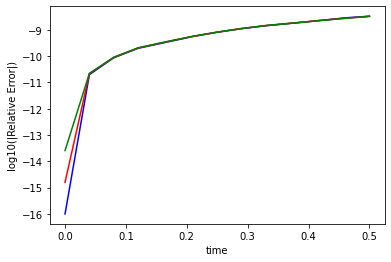

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# from https://stackoverflow.com/questions/52386747/matplotlib-check-for-empty-plot
import numpy
time__arr = []
lgerr_arr = []
for i in [24, 48, 96]:
    t, log10error, num, exact = numpy.loadtxt(fname='output_resolution_'+str(i)+'cubed.txt', delimiter=' ', unpack=True)
    time__arr.append(t)
    lgerr_single_dataset = []
    for log10err_onept in log10error:
        lgerr_single_dataset.append(log10err_onept + 4*np.log10(i/(24.0)))
    lgerr_arr.append(lgerr_single_dataset)

fig, ax = plt.subplots()
ax.set_xlabel('time')
ax.set_ylabel('log10(|Relative Error|)')
ax.plot(time__arr[0], lgerr_arr[0], color='b')
ax.plot(time__arr[1], lgerr_arr[1], color='r')
ax.plot(time__arr[2], lgerr_arr[2], color='g')

<a id='latex_pdf_output'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ScalarWave.pdf](Tutorial-ScalarWave.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-ScalarWave")